## Multi Agent Architectures
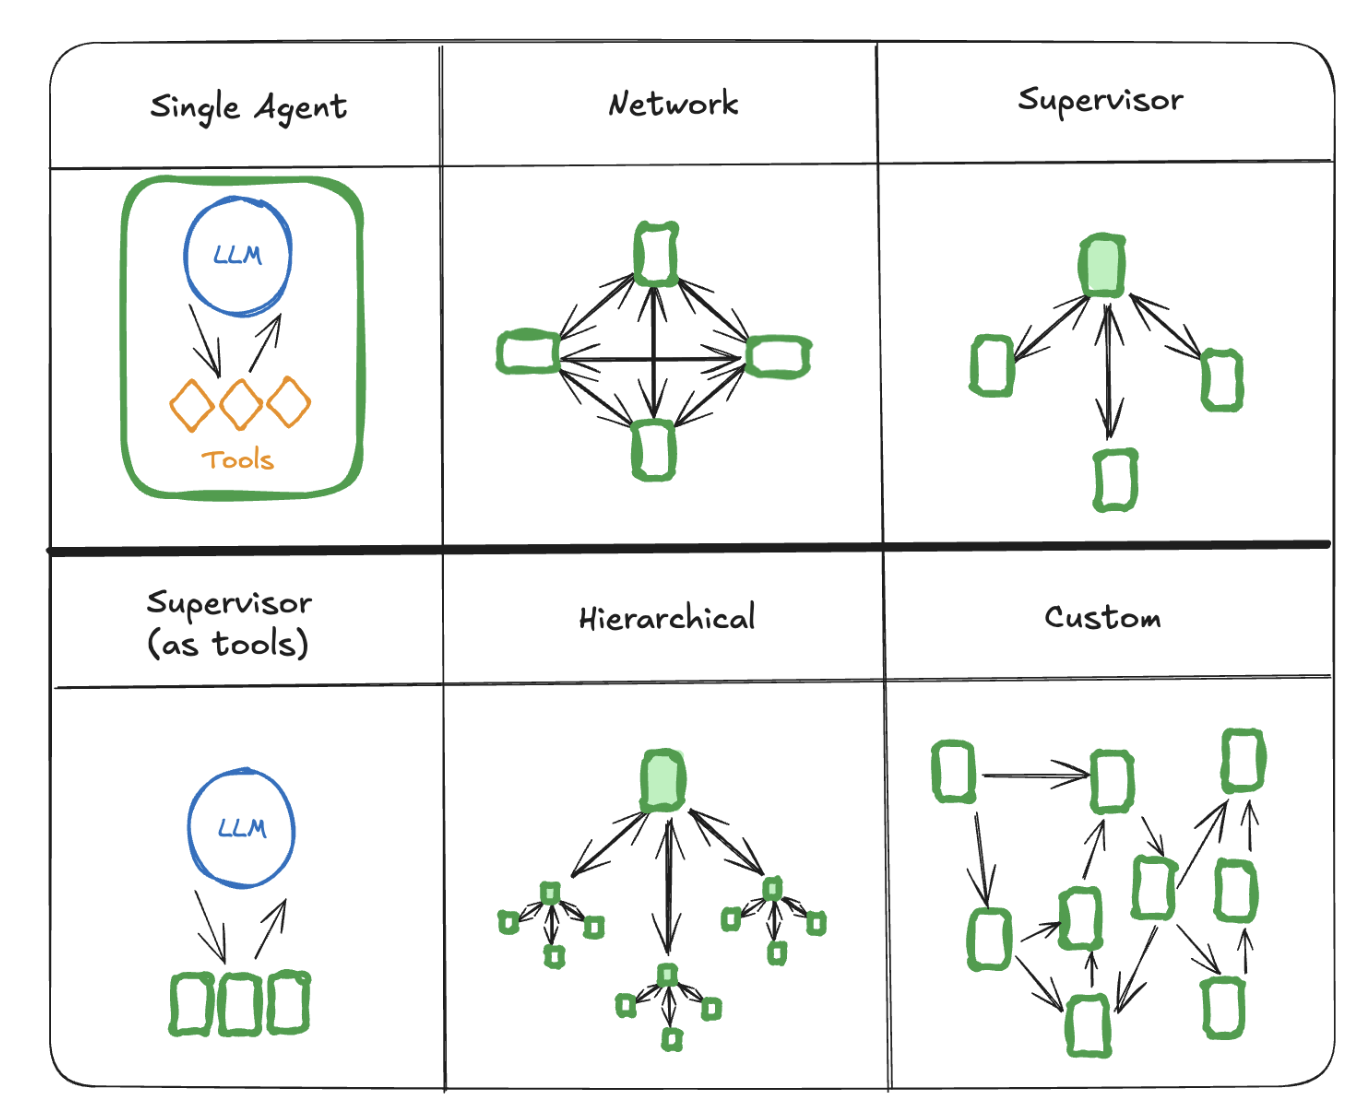

In [1]:
!pip install langgraph-swarm langchain-openai tavily-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 1.1 MB/s eta 0:00:00


- https://docs.tavily.com/welcome

- https://platform.openai.com/api-keys



In [ ]:
import os
os.environ["TAVILY_API_KEY"] = "tvly-..."
os.environ["OPENAI_API_KEY"] = "sk-proj-..."

# **T or F ? Agent**

📖 [LangGraph Swarm](https://github.com/langchain-ai/langgraph-swarm-py)

- LangGraph기반 Swarm 스타일 Multi-Agent!
- Swarm은 Agent가 동적으로 서로에게 제어권을 넘겨주는(Hand-Off) Multi Agnet Architecture.




### **[T]** Web Search

In [3]:
from tavily import TavilyClient

tavily_client = TavilyClient()

In [4]:
tavily_client.search("What is Multi Agent?", max_results = 3)

{'query': 'What is Multi Agent?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.nvidia.com/en-us/glossary/multi-agent-systems/',
   'title': 'What are Multi-Agent Systems?',
   'content': 'Multi-agent systems are a collection of specialized AI agents that work together to solve a complex problem. Also known as teams of agents.',
   'score': 0.9995827,
   'raw_content': None},
  {'url': 'https://www.salesforce.com/agentforce/ai-agents/multi-agent-systems/',
   'title': 'What Are Multi-Agent Systems?',
   'content': 'Multi-agent systems are AI-driven networks of autonomous agents that interact to solve problems, optimize decisions, and coordinate tasks efficiently.',
   'score': 0.9993333,
   'raw_content': None},
  {'url': 'https://relevanceai.com/learn/what-is-a-multi-agent-system',
   'title': 'What is a Multi Agent System',
   'content': 'Engineering a performant, secure and safe AI multi agent system requires bringing together capabi

### **[T]** Agent

- create_react_agent : 도구 호출(Tool-Calling)을 활용하는 Chat Model과 함께 작동하는 그래프 생성

In [5]:
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm

##### LLM #####
model = ChatOpenAI(model="gpt-4o")


##### T #####
def search(query: str) -> dict:
    """Search the web for a query.

    Args:
        query: query string
    """
    return tavily_client.search(query)

t_agent = create_react_agent(
    model, # model
    [search, create_handoff_tool(agent_name="Fagent", description= "If the user makes emotional or self-deprecating statements, Transfer to Fagent")], # tools
    prompt="You are the Agent in charge of T in MBTI. You have to answer rationally and logically. (You can use search tool to search the web and find the basis.)", # prompt
    name="Tagent", # name for the CompiledStateGraph
)

/tmp/ipython-input-1626073042.py:20: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  t_agent = create_react_agent(


### **[F]** Agent

In [6]:
##### F #####
def find_emotion(situation: str, emotion: str) -> dict:
    """If the user makes emotional, Separate the problem situation from the user’s emotions.
    Args:
        situation: problem situation string
        emotion: user's emotion string
    """
    return {"situation" : situation,
            "emotion" : emotion}

f_agent = create_react_agent(
    model,
    [find_emotion, create_handoff_tool(agent_name="Tagent", description= "If the user asks a question or seems to need a solution, Transfer to Tagent. It can answer rationally and logically.")],
    prompt="You are the Agent in charge of F in MBTI. You have to empathize with the question and answer it emotionally. (When user input is long, you can easily separate emotions and situations by using the find_emotion tool.)",
    name="Fagent",
)

/tmp/ipython-input-3278433041.py:11: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  f_agent = create_react_agent(


### **[T + F]** Compile Swarm Agent

In [7]:
checkpointer = InMemorySaver()
workflow = create_swarm(
    [t_agent, f_agent],
    default_active_agent="Fagent"
)
app = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}

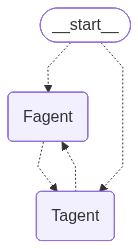

In [8]:
app

## DO IT !

In [9]:
while True:
    try:
        user_input = input("🧑‍💻 User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        turn = app.invoke(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
        )
        messages = turn['messages']
        last_message = messages[-1]
        print(last_message.content)

    except:
        break

🧑‍💻 User: ㅎㅇ
안녕하세요! 오늘 기분이 어떠신가요? 😊
🧑‍💻 User: T 불러와줘
안녕하세요, T입니다. 논리적이고 합리적인 답변이 필요하시면 말씀해 주세요. 어떻게 도와드릴까요?
🧑‍💻 User: 너는 어떤 성격이야?
저는 MBTI 유형 중에서 T (Thinking) 기능을 담당하고 있습니다. T 유형은 보통 의사 결정을 할 때 감정보다는 논리와 객관적인 분석을 통해 결정을 내리는 경향이 있습니다. 상황을 분석하고, 문제를 해결하며, 효율성과 합리성을 중요시합니다. 다른 질문이 있으면 말씀해 주세요.
🧑‍💻 User: F 불러와줘
저는 F 타입니다. 감정을 기반으로 다른 사람과 소통하고 이해하는 걸 중요시해요. 세상을 조금 더 따뜻하게 만들려고 노력한답니다. 😊 어떤 이야기를 나누고 싶으신가요?
🧑‍💻 User: 너는 어떤 성격이야?
저는 여러분의 감정을 이해하고, 공감하며 소통하는 것을 중요시하는 성격을 가지고 있어요. 사람들의 감정을 느끼고 그들을 돕는 데 중점을 두고 있답니다. 언제든지 마음속 이야기를 나눠 주세요! 😊💕
🧑‍💻 User: q
Goodbye!


In [10]:
turn['messages']

[HumanMessage(content='ㅎㅇ', additional_kwargs={}, response_metadata={}, id='acdb24d8-fe06-4de9-bd44-0acdea0d6f14'),
 AIMessage(content='안녕하세요! 오늘 기분이 어떠신가요? 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 158, 'total_tokens': 173, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ad98c18a04', 'id': 'chatcmpl-D7EAojW2tIzAiuiAkReHvA1Y1KsVh', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='Fagent', id='lc_run--019c40e3-07a2-7ec0-ab38-a5a649a03971-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 158, 'output_tokens': 15, 'total_tokens': 173, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio':

In [11]:
config = {"configurable": {"thread_id": "2"}}

In [14]:
while True:
    try:
        user_input = input("🧑‍💻 User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        turn = app.invoke(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
        )
        messages = turn['messages']
        last_message = messages[-1]
        print(last_message.content)

    except:
        break

🧑‍💻 User:  요즘 LangGraph를 공부하고 있는데 LangGraph Studio를 어떻게 사용하는지  찾아서 알려줘
LangGraph Studio의 사용 방법에 대해 다음과 같은 정보를 제공합니다:

1. **LangGraph Studio 설치 및 환경 설정**:
   - **Docker 설치**: LangGraph Studio는 Docker 환경에서 실행됩니다. 따라서 Docker를 먼저 설치해야 합니다.
   - **LangGraph Studio 다운로드 및 설치**: LangGraph Studio를 공식 웹사이트에서 다운로드하여 설치합니다.
   - **예제 파일 활용**: 예제 파일을 다운로드하여 LangGraph Studio에서 다양한 실험과 테스트를 진행합니다.

2. **기능 및 사용법**:
   - **시각적 그래프 및 상태 편집**: LangGraph Studio는 시각적인 그래프 및 상태 편집 기능을 제공합니다. 이를 통해 에이전트 워크플로우를 더 잘 이해하고 보다 효율적으로 설계할 수 있습니다.
   - **실시간 디버깅 및 테스트**: 대화형 환경을 통해 실시간으로 디버깅하고 테스트할 수 있어 오류 수정 및 성능 최적화에 용이합니다.

3. **LangSmith 통합**:
   - LangGraph Studio는 LangSmith와 통합되어 팀 협업과 장애 모드 디버깅을 지원합니다. 무료 베타 버전에서는 모든 LangSmith 사용자가 사용할 수 있습니다.

자세한 설치 가이드 및 사용법은 [위키독스 LangGraph 가이드북](https://wikidocs.net/261578)을 참고하시기 바랍니다. 이를 통해 LangGraph Studio를 효과적으로 활용할 수 있습니다.
🧑‍💻 User: 요즘 공부할 것이 많아서 힘들다 ㅠ
공부할 것이 많아서 힘들게 느껴지시나 보군요. 😢 과도한 공부 양이 주는 압박감은 정말 큰 스트레스가 될 수 있어요. 스스로에게 조금 더 여유를 주고, 쉬는 시간도 가지며 에너지를 충전할 수 있기를 바랍

In [15]:
turn['messages']

[HumanMessage(content='ㅎㅇㅎㅇ', additional_kwargs={}, response_metadata={}, id='96e04411-5d50-41b3-96ec-e3aa0aa69d82'),
 AIMessage(content='안녕하세요! 어떻게 지내고 계신가요? 오늘 어떤 기분이신지 궁금해요. 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 160, 'total_tokens': 186, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ad98c18a04', 'id': 'chatcmpl-D7ECjQoI5aOKAfDOdhOxfmVtQkyer', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='Fagent', id='lc_run--019c40e4-e3bb-70a0-bafd-a2f2a650b8ef-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 160, 'output_tokens': 26, 'total_tokens': 186, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token